# Balancing Robot simulation

This notebook goes through the development of a controller for stabilizing a balancing robot.\
To robot is represented schematically with an inverted pendulum that is coupled with a wheel at its fulcrum. The coupling between pendulum and wheel is done with a motor. The goal is to develop a controller that can stabilize the system by controlling the motor torque.\
The sequence of steps performed to achieve the goal are the following:
 - Derive the non linear equations of motion for the robot.
 - Make a linear model near the upside down equilibrium point.
 - Develop a controller using MATLAB.
 - Simulate the resulting system in the Mujoco framework. 


## Deriving the equations of motion

![Inverted Pendulum Drawing](../Images/inverted_pendulum_drawing.png "Inverted Pendulum Drawing")

Since we are only interested in the motion along the $x$ axis we can ignore the force of gravity and the reaction force from the flor. To derive the equation we use the Lagrangian mechanics approach. In Lagrangian mechanic we donn't need to calculate the forces acting on an object at every instant in time, instead we derive expression that track the kinetic and potential energy of the system. We define the value $L$ as the Lagrangian of the system as:

$L \triangleq T - V$

Where $T$ is the total kinetic energy in the system and $V$ is the total potential energy. Its a property of all systems that their behavior always follows a path that minimizes tha action $S = \int_{t_1}^{t_2}L(t)dt$. The function that minimizes the action $S$ is easily found solving the following equation, where $q$ is the variable for with we are deriving the equation of motion and $Q_i$ is the sum of all the external forces acting on $q$. 

$\frac{d}{dt}\frac{\partial L}{\partial \dot{q_i}} - \frac{\partial L}{\partial x} = Q_i$

### Kinematic Constraints
The kinematic constraints describe the position ($\vec{P_1}, \vec{P_2}$) and velocities ($\vec{v_1}, \vec{v_2}$) of the two masses using the chosen state variables, $x$ for the horizontal position of the mass $m_2$ and $\theta$ for the angle of the pendulum.

$\vec{P_1} = x\hat{i}$

$\vec{P_2} = \vec{P_1} - l\sin(\theta)\hat{i} + l\cos(\theta)\hat{j} = (x - l\sin(\theta)\hat{i} + l\cos(\theta)\hat{j}$

$\vec{v_1} = \frac{d\vec{P_1}}{dt} = \dot{x}\hat{i}$

$\vec{v_2} = \frac{d\vec{P_2}}{dt} = \frac{d}{dt}\left[\left(x-l\sin(\theta)\right)\hat{i} + l\cos(\theta)\hat{j}\right] = \left(\dot{x} - l\dot{\theta}\cos(\theta)\right)\hat{i} - l\dot{\theta}\sin(\theta)\hat{j}$

### Potential Energy
Only the mass $m_2$ is free to move in the $\hat{j}$ direction, the total potential energy is the potential energy of the mass $m_2$
$V = g m_2 l\cos(\theta)$

### Kinetic Energy
The total kinetic energy is the sum of the kinetic energies for all the masses. The mass $m_2$ moves in the $\hat{i}$ and $\hat{j}$ directions, the kinetic energies for each orthogonal direction are summed independently.

$
\begin{aligned}
T &= \sum_{k=1}^{N} m_kv_k^2 = \frac{1}{2}m_1\dot{x}^2 + \frac{1}{2}m_2\left(\dot{x}-l\dot{\theta}\cos(\theta)\right)^2 + \frac{1}{2}m_2l^2\dot{\theta}^2\sin^2(\theta)\\
  &= \frac{1}{2}m_1\dot{x}^2 + \frac{1}{2}m_2\left(\dot{x}^2 + l^2\dot{\theta}^2\cos^2(\theta) - 2\dot{x}l\dot{\theta}\cos(\theta)\right) + \frac{1}{2}m_2l^2\dot{\theta}^2\sin^2(\theta)\\
  &= \frac{1}{2}m_1\dot{x}^2 + \frac{1}{2}m_2\dot{x}^2 + \frac{1}{2}m_2l^2\dot{\theta}^2\cos^2(\theta) - m_2\dot{x}l\dot{\theta}\cos(\theta) + \frac{1}{2}m_2l^2\dot{\theta}^2\sin^2(\theta)\\
  &= \frac{1}{2}\left(m_1+m_2\right)\dot{x}^2 - m_2\dot{x}\dot{\theta}l\cos(\theta) + \frac{1}{2}m_2l^2\dot{\theta}^2\left(\cos^2(\theta) + \sin^2(\theta)\right)\\
  &= \frac{1}{2}\left(m_1+m_2\right)\dot{x}^2 - m_2\dot{x}\dot{\theta}l\cos(\theta) + \frac{1}{2}m_2l^2\dot{\theta}^2
\end{aligned}
$

### Lagrangian

$L \triangleq T - V = \frac{1}{2}\left(m_1+m_2\right)\dot{x}^2 - m_2\dot{x}\dot{\theta}l\cos(\theta) + \frac{1}{2}m_2l^2\dot{\theta}^2 - gm_2l\cos(\theta)$


### Equations of Motion
The equation are derived for the two state variables independently by solving the equation:

$\frac{d}{dt}\frac{\partial L}{\partial \dot{q_i}} - \frac{\partial L}{\partial x} = Q_i$

#### Solving for $x$

$\frac{d}{dt}\frac{\partial L}{\partial \dot{x}} - \frac{\partial L}{\partial x} = F(t)$

$\ddot{x} = -\frac{lm_2\sin(\theta)}{m_1+m_2}\dot{\theta}^2 + \frac{lm_2\cos(\theta)}{m_1+m_2}\ddot{\theta} + \frac{1}{(m_1+m_2)r}\tau$

#### Solving for $\theta$

$\frac{d}{dt}\frac{\partial L}{\partial \dot{\theta}} - \frac{\partial L}{\partial \theta} = \tau(t)$

$\ddot{\theta} = \frac{g}{l}\sin(\theta) + \frac{\cos(\theta)}{l}\ddot{x} + \frac{1}{m_2 l}\tau$

$\ddot{\theta} = \frac{m_1+m_2}{m_1+m_2\sin^2(\theta)}\frac{g}{l}\sin(\theta) - \frac{m_2\sin(\theta)\cos(\theta)}{m_1+m_2\sin^2(\theta)}\dot{\theta}^2 + \frac{l m_2 \cos(\theta) + r (m_1 + m_2)}{(m_1 + m_2 \sin^2(\theta))l^2 r m_2}\tau$

## Linearization around the equilibrium point

Non linear equation are ugly, assuming that the pendulum wont deviate much from the upside down equilibrium point, we can approximate the motion of the pendulum with a linear equation.\
To linearize di equation we just substitute any non linear term with its value at the equilibrium point plus its first derivative evaluated at the equilibrium point. Lets sai $f(x)$ is a non linear function of the variable $x$ and $x_0$ is the point around witch we want to get a linear approximation:

$f(x) \approx f(x_o) + \frac{\partial f(x)}{\partial x}\big\rvert_{x_0} (x - x_0)$

The equilibrium point for the pendulum is ($\theta = 0, \dot{\theta} = 0$) so the following approximation are made: $\sin(\theta)=\theta, \,\cos(\theta)=1, \,\dot{\theta}^2=0, \,\sin^2(\theta)=0$

$\ddot{\theta} = \frac{m_1 + m_2}{m_1}\frac{g}{l}\theta +\frac{l m_2 + r (m_1 + m_2)}{m_1 m_2 l^2 r}\tau $

## Definition of the model in the mujoco framework

""

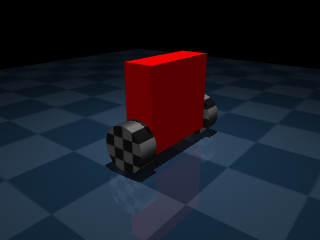

In [1]:
# Definition of the model in the mujoco framework and rendering of a steel picture

import mujoco
import mediapy as media
import numpy as np
import matplotlib.pyplot as plt
import csv

xml = """
<mujoco model="balancing robot">
    <option integrator="RK4" timestep="0.001"/>

    <visual>
        <global offheight="2160" offwidth="3840"/>
        <quality offsamples="8"/>
    </visual>

    <asset>
        <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
            rgb2=".2 .3 .4" width="300" height="300"/>
        <material name="grid" texture="grid" texrepeat="8 8" reflectance=".2"/>

        <texture name="wheel" type="2d" builtin="checker" rgb1=".1 .1 .1"
            rgb2=".5 .5 .5" width="300" height="300"/>
        <material name="wheel" texture="wheel" texrepeat="2 2" reflectance=".2"/>
    </asset>

    <worldbody>
        <geom size="1 1 .01" type="plane" material="grid"/>
        <light pos="0 0 1"/>
        <camera name="closeup" pos=".3 -.4 .25" xyaxes="1 .8 0 0 1 2"/>
        <body name="top" pos="0 0 0">
            <joint name="top" type="free"/>
            <site name="IMU" pos="0 0 .04"/>
            <geom name="body" type="box" size=".0275 .080 .075" pos="0 0 .095" mass=".46" rgba="1 0 0 1" contype="2" conaffinity="2"/>
            <body name="right wheel" pos="0 0 .02">
                <joint name="right wheel" type="hinge" axis="0 1 0" pos="0 0 .02" damping="0.0001"/>
                <geom name="right wheel" type="cylinder" pos="0 -0.1 .02" size="0.04 .0175" mass=".04" zaxis="0 1 0" material="wheel"/>
            </body>
            <body name="left wheel" pos="0 0 .02">
                <joint name="left wheel" type="hinge" axis="0 1 0" pos="0 0 .02" damping="0.0001"/>
                <geom name="left wheel" type="cylinder" pos="0 0.1 .02" size="0.04 .0175" mass=".04" zaxis="0 1 0" material="wheel"/>
            </body>
        </body>
    </worldbody>

    <actuator>
        <motor name="motor right" joint="right wheel" gear="1"/>
        <motor name="motor left" joint="left wheel" gear="1"/>
    </actuator>

    <sensor>
        <accelerometer name="accelerometer" site="IMU"/>
        <framezaxis name="top z axis" objtype="body" objname="top"/>
        <frameyaxis name="top y axis" objtype="body" objname="top"/>
    </sensor>
    
</mujoco>
"""
# Make model and data
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

# Make renderer, render and show the pixels
with mujoco.Renderer(model) as renderer:
    mujoco.mj_forward(model, data)
    renderer.update_scene(data, camera="closeup")
    media.show_image(renderer.render())

## Comparing the model with simulation

The following code simulates the system initialized with $\theta = 0.5$ and compares the simulation result with the numerical solution computed in MATLAB. As can bee seen from the graph the two plots have the same shape but slightly different oscillation frequencies.

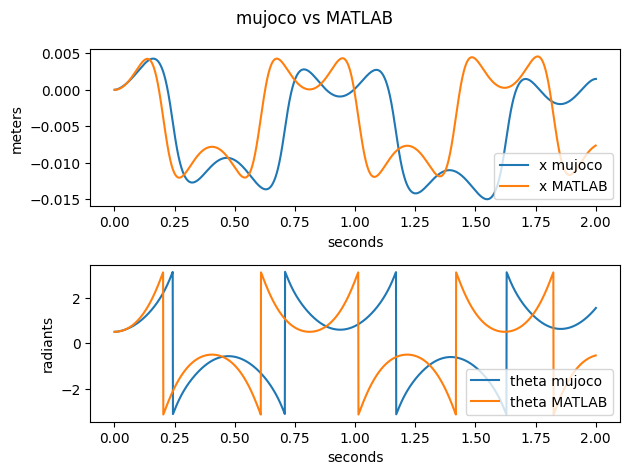

In [9]:
# Comparison between the mathematical model simulated in MATLAB and the mujoco simulation

# Configuration
duration = 2    # (seconds)
framerate = 60  # (Hz)
height = 320
width = 480
theta0 = 0.5    # Initial angle


def project_onto_plane(vec, normal):
    normal = normal / np.linalg.norm(normal)
    return vec - np.dot(vec, normal) * normal


def signed_angle_between(v1, v2, axis):
    v1_proj = project_onto_plane(v1, axis)
    v2_proj = project_onto_plane(v2, axis)

    v1_proj /= np.linalg.norm(v1_proj)
    v2_proj /= np.linalg.norm(v2_proj)

    dot = np.dot(v1_proj, v2_proj)
    cross = np.cross(v1_proj, v2_proj)
    angle = np.arctan2(np.dot(cross, axis / np.linalg.norm(axis)), dot)
    return angle  # radians


frames = []
times = []
theta = []
pos_x = []

# Make model and data
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
options = mujoco.MjvOption()
mujoco.mjv_defaultOption(options)

# Set initial conditions
mujoco.mj_resetData(model, data)
data.joint('top').qpos = [0, 0, 0, np.cos(theta0/2), 0, np.sin(theta0/2), 0]

# Simulate and display video
with mujoco.Renderer(model, height, width) as renderer:
    while data.time < duration:
        mujoco.mj_step(model, data)
        # Reading variables
        qpos = data.joint('top').qpos.copy()
        z_axis = data.sensor('top z axis').data.copy()
        y_axis = data.sensor('top y axis').data.copy()
        # Update lists
        times.append(data.time)
        pos_x.append(-qpos[0]*0.1) # Don't know why the units don't match
        theta.append(signed_angle_between([0, 0, 1], z_axis, y_axis))
        # Render frame
        if len(frames) < data.time * framerate:
            renderer.update_scene(data, camera="closeup")
            pixels = renderer.render()
            frames.append(pixels)

media.show_video(frames, fps=framerate)

# Load MATLAB simulation from .csv
csv_time = []
csv_x = []
csv_theta = []
with open('../MATLAB/balancing_robot.csv', newline='') as csvfile:
    data = csv.reader(csvfile, delimiter=',')
    for row in data:
        csv_time.append(float(row[0]))
        x = float(row[1])
        th = float(row[2])
        if th > np.pi: th = th - 2*np.pi
        if th < -np.pi: th = th + 2*np.pi
        csv_x.append(x)
        csv_theta.append(th)

# Plot mujoco simulation vs MATLAB simulation
fig, axs = plt.subplots(2)
fig.suptitle('mujoco vs MATLAB')
# Plot x
axs[0].plot(np.asarray(times), np.asarray(pos_x), label="x mujoco")
axs[0].plot(np.asarray(csv_time), np.asarray(csv_x), label="x MATLAB")
axs[0].set_ylabel('meters')
axs[0].set_xlabel('seconds')
axs[0].legend(frameon=True, loc='lower right')
plt.tight_layout()
# Plot theta
axs[1].plot(np.asarray(times), np.asarray(theta), label="theta mujoco")
axs[1].plot(np.asarray(csv_time), np.asarray(csv_theta), label="theta MATLAB")
axs[1].set_ylabel('radiants')
axs[1].set_xlabel('seconds')
axs[1].legend(frameon=True, loc='lower right')
plt.tight_layout()

## Controlling the agent

In order to design the controller we first need to derive a linear model of the system on witch to tune the controller. From the linearized equations found earlier we can write the state space representation of the system, the state vector $X = [x, \dot{x}, \theta, \dot{\theta}]$ is used.

$
\begin{aligned}
    \begin{bmatrix}
        \dot{X_0}\\
        \dot{X_1}\\
        \dot{X_2}\\
        \dot{X_3}
    \end{bmatrix}
    =
    \begin{bmatrix}
        0 & 1 & 0                & 0\\
        0 & 0 & g\frac{m_2}{m_1} & 0\\
        0 & 0 & 0                & 1\\
        0 & 0 & \frac{m_1+m_2}{m_1}\frac{g}{l} & 0
    \end{bmatrix}
    \begin{bmatrix}
        X_0\\
        X_1\\
        X_2\\
        X_3
    \end{bmatrix}
    +
    \begin{bmatrix}
        0\\
        \frac{l+r}{m_1 l r}\\
        0\\
        \frac{l m_2 + r(m_1+m_2)}{m_1 m_2 l^2 r}
    \end{bmatrix}
    \tau
\end{aligned}
$

### Simple angle controller

This controller looks only at the angle of the pendulum and drives the motor to keep the balance. It doesn't care for the position so we won't be able to drive the robot around.



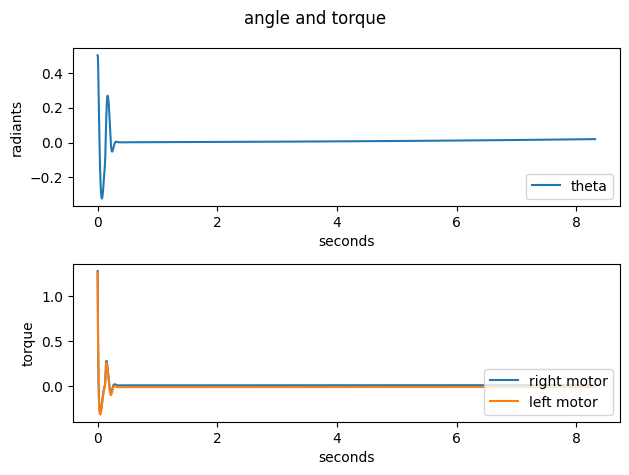

In [44]:
# Controlling the robot with a discrete time controller

class Controller:

	def __init__(self):
		self.b = [2.531, -4.988, 2.457]
		self.a = [1.861, -0.8611]
		self.x = [0] * len(self.b)
		self.y = [0] * len(self.a)
		

	def compute(self, imu, theta: float):

		# shift current value into the buffer at index 0
		self.x = [theta] + self.x[0:-1]

		# Compute value
		y = np.sum(np.multiply(self.b, self.x)) + np.sum(np.multiply(self.a, self.y))

        # shift current value of y into the buffer at index 0
		self.y = [y] + self.y[0:-1]

		# Compute motor torque
		turning = 0.01
		right_motor_torque = y
		left_motor_torque = y

		return [right_motor_torque + turning, left_motor_torque - turning]


def main():
    n_frames = 500
    height = 240
    width = 320
    frames = []
    fps = 60.0
    times = []
    sensordata = []
    theta = []
    motor = []

    controller = Controller()

    # Make model and data
    model = mujoco.MjModel.from_xml_string(xml)
    data = mujoco.MjData(model)
    options = mujoco.MjvOption()
    mujoco.mjv_defaultOption(options)

    # constant actuator signal
    mujoco.mj_resetData(model, data)
    data.joint('top').qpos = [0, 0, 0, np.cos(theta0/2), 0, np.sin(theta0/2), 0]
	
	# Simulate and display video.
    with mujoco.Renderer(model, height, width) as renderer:
        for i in range(n_frames):
            while data.time < i/fps:
                mujoco.mj_step(model, data)
                times.append(data.time)
				#theta.append(get_angle(data))
                z_axis = data.sensor('top z axis').data.copy()
                y_axis = data.sensor('top y axis').data.copy()
                qpos = data.joint('top').qpos.copy()
                theta.append(signed_angle_between([0, 0, 1], z_axis, y_axis))
                acc_data = data.sensor('accelerometer').data.copy()
                command = controller.compute(acc_data, theta[-1])
                motor.append(command)
                data.ctrl = command
                sensordata.append(acc_data)
            renderer.update_scene(data, camera="closeup")
            frame = renderer.render()
            frames.append(frame)

    media.show_video(frames, fps=fps)   

    # Plot mujoco simulation vs MATLAB simulation
    fig, axs = plt.subplots(2)
    fig.suptitle('angle and torque')
    # Plot x
    axs[0].plot(np.asarray(times), np.asarray(theta), label="theta")
    axs[0].set_ylabel('radiants')
    axs[0].set_xlabel('seconds')
    axs[0].legend(frameon=True, loc='lower right')
    plt.tight_layout()
    # Plot theta
    axs[1].plot(np.asarray(times), np.asarray([x[0] for x in motor]), label="right motor")
    axs[1].plot(np.asarray(times), np.asarray([x[1] for x in motor]), label="left motor")
    axs[1].set_ylabel('torque')
    axs[1].set_xlabel('seconds')
    axs[1].legend(frameon=True, loc='lower right')
    plt.tight_layout()


if __name__=="__main__":
	main()